In [1]:
import pandas as pd
import json
import re
import csv
import numpy as np
import math
import codecs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load Data

In [36]:
df = pd.read_csv('data/out_test.csv')
len(df)

10778

## Clean Data

### Catalogue Info
- Acquisition date: before 2012 approx. the date of acquisition is in the 'Inventarnummer' field. It contains the year and the how manyth document it is in a given year (linear time information). After 2012 the date of acquisition is in the acquisition date field
- Volumes with parentid: Volumes of works have a parent entry in the bvb catalogue, all the children point to it in the parentid field. If the documents are present in the BH, the children have a shelf number, the parent document doesn't. Often neither contain subjects (as they are e.g. encyclopedias)


In [37]:
# drop documents without subject labels

df.dropna(subset=['subjects'], inplace=True)
df['subjects'].isna().sum()

3476

In [54]:
# drop documents that belong to a Volume of works (with parentid)

df[df.parentId.isna()]



,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle,subject_labels,subject_list,embedding_x,embedding_y,cluster
2,BV000024767,ger,"Burckhardt, Jacob",Über das Studium der Geschichte,NaN,Jacob Burckhardt. Nach den Handschriften herau...,München,Verlag C.H.Beck,1982,"Ganz, Peter F.|Ziegler, Ernst","Geschichtsstudium|Burckhardt, Jacob",s|p,NaN,NaN,"[s, p]",Geschichtsstudium BurckhardtJacob,127,-298,-1
3,BV000025578,ger,"Herzog, Werner",Fitzcarraldo,NaN,Werner Herzog,München u.a.,Hanser,1982,NaN,"Fitzcarraldo|Herzog, Werner",u|p,NaN,NaN,"[u, p]",Fitzcarraldo HerzogWerner,229,-71,-1
5,BV000026609,ger,"Pfeiffer, Rudolf",Die klassische Philologie von Petrarca bis Mom...,NaN,Rudolf Pfeiffer,München,Verlag C.H.Beck,1982,NaN,"Deutschland|Klassische Philologie|Petrarca, Fr...",g|s|p,NaN,A history of classical scholarship from 1300-1850,"[g, s, p]",Deutschland KlassischePhilologie PetrarcaFranc...,-166,-460,-1
6,BV000026897,ger,"Wimmer, Otto",Lexikon der Namen und Heiligen,NaN,Otto Wimmer ; Hartmann Melzer,Innsbruck [u.a.],Tyrolia-Verl.,1982,"Melzer, Hartmann",Personenname,s,NaN,NaN,[s],Personenname,136,-192,-1
10,BV000028770,ger,"Rohr, René R. J.",Die Sonnenuhr,NaN,René R. J. Rohr,München,Callwey,1982,NaN,Sonnenuhr,s,NaN,Les cadrans solaires,[s],Sonnenuhr,251,-98,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10757,BV021783129,fre,NaN,Fragmenta,NaN,NaN,Turnhout,Brepols,2007-2014,NaN,Römisches Reich|Kultur,g|s,NaN,NaN,"[g, s]",RömischesReich Kultur,438,68,41
10761,BV021784545,ita,"Stefani, Ottorino",Luigi Serena,NaN,Ottorino Stefani,Ponzano (Treviso),Vianello,2006,"Serena, Luigi","Serena, Luigi",p,NaN,NaN,[p],SerenaLuigi,136,-328,-1
10765,BV021784616,eng,"Flood, John L.",Poets laureate in the Holy Roman Empire,NaN,John L. Flood,Berlin [u.a.],<<de>> Gruyter,2006,NaN,Heiliges Römisches Reich|Biografie,g|s,NaN,NaN,"[g, s]",HeiligesRömischesReich Biografie,229,-290,138
10769,BV021785042,ita,"Cametti, Alberto","Cristina di Svezia, l'arte musicale e gli spet...",NaN,Alberto Cametti,Roma,Nuova Antologia,1911,NaN,"Christine (Schweden, Königin)|Musik",p|s,NaN,NaN,"[p, s]",Christine(SchwedenKönigin) Musik,417,-102,-1


## Category labels

In [41]:
#based on the subject types
df['subject_labels'] = df['subject_types'].str.split('|')

In [42]:
df['subject_labels']

0              [b]
1        [p, g, s]
2           [s, p]
3           [u, p]
4              [p]
           ...    
10768       [g, s]
10769       [p, s]
10770       [p, s]
10772    [u, s, p]
10773       [p, s]
Name: subject_labels, Length: 7302, dtype: object

## Tokenize

In [43]:
# cleaning up the subject: getting rid of commas and spaces, replacing the | with spaces
df['subject_list'] = df['subjects'].apply(lambda x: str(x).replace(',', '').replace(' ', '').replace('|', ' '))

In [44]:
df['subject_list']

0                     DeutschesLiteraturarchivMarbach
1        BurckhardtJacob Deutschland Historienmalerei
2                   Geschichtsstudium BurckhardtJacob
3                           Fitzcarraldo HerzogWerner
4                                     RauzziniFilippo
                             ...                     
10768                             SanTorpè Kirchengut
10769                Christine(SchwedenKönigin) Musik
10770                                Hypsipyle Mythos
10772    ChaucerGeoffrey Rezeption Christine(dePisan)
10773            WinckelmannJohannJoachim Archäologie
Name: subject_list, Length: 7302, dtype: object

## Bag of words

In [11]:
vectorizer = CountVectorizer(min_df=5)
subject_doc_matrix = vectorizer.fit_transform(df.subject_list)

In [12]:
subject_doc_matrix

<7302x429 sparse matrix of type '<class 'numpy.int64'>'
	with 7762 stored elements in Compressed Sparse Row format>

### UMAP

In [13]:
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import umap.plot
from pointgrid import align_points_to_grid

In [18]:
reducer = UMAP(random_state=42, n_components = 2, metric='cosine')
#reducer = UMAP(random_state=42, n_components = 2, metric='hellinger')

# Using hellinger metric the points without neighbors are mapped to nan. 

map = reducer.fit(subject_doc_matrix)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


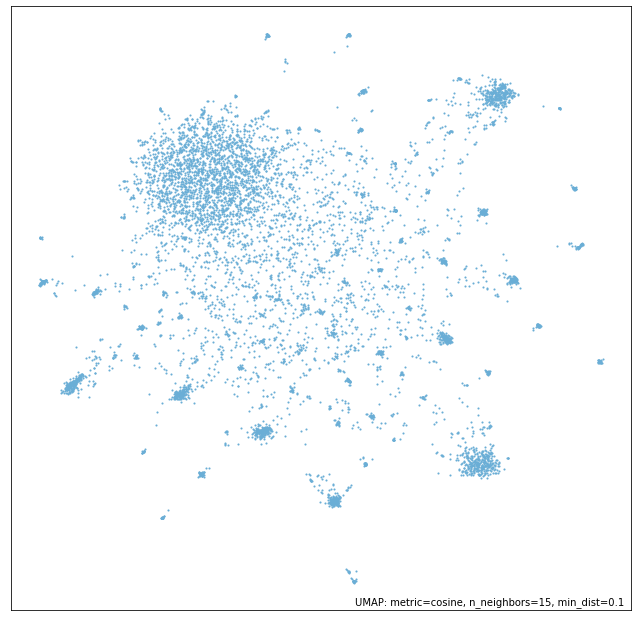

In [19]:
f = umap.plot.points(map)

In [20]:
map.embedding_

array([[ -9.323208 ,   6.843728 ],
       [-12.601337 ,   1.5100389],
       [-11.042988 ,   4.558782 ],
       ...,
       [ -7.7981596,   6.7821555],
       [ -7.443159 ,  -2.4787188],
       [ -4.118695 ,   2.9235313]], dtype=float32)

In [21]:
# Normalize 

embedding = map.embedding_ * 100 # Multiply by 100
embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position

ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set value starting from 0

embedding[:, 0] = embedding[:, 0] - embedding[:, 0].min()
embedding[:, 1] = embedding[:, 1] - embedding[:, 1].min()

# # Set origin at the middle

ptp = np.ptp(embedding, axis=0)
embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

embedding = embedding.astype(int) # Set integer

embedding

array([[ 357, -124],
       [-204, -457],
       [ 127, -298],
       ...,
       [ 353,   30],
       [-570,   64],
       [ -34,  381]])

# Cluster Identification

In [22]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_method ='leaf')

clusterer.fit(embedding)
clusters = clusterer.labels_

values = set(clusters)
if -1 in values: values.remove(-1)

#clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

len(clusters)


7302

In [23]:
clusters

array([181,  -1,  -1, ...,  -1,   0,  13], dtype=int64)

## Export 

In [45]:
# add coordinates to dataframe

df['embedding_x']  = embedding[:,0]
df['embedding_y']  = embedding[:,1]

# add cluster to dataframe

df['cluster'] = clusters

In [46]:
df.head()

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle,subject_labels,subject_list,embedding_x,embedding_y,cluster
0,BV000023649,ger,NaN,"Deutsches Literaturarchiv, Schiller-Nationalmu...",NaN,vorgestellt von den Mitarbeitern,Marbach a. Neckar,NaN,1982,NaN,Deutsches Literaturarchiv Marbach,b,BV040655651,Marbacher Schriften,[b],DeutschesLiteraturarchivMarbach,357,-124,181
1,BV000024214,ger,"Schlink, Wilhelm",Jacob Burckhardt und die Kunsterwartung im Vor...,NaN,Wilhelm Schlink,Wiesbaden,Steiner,1982,NaN,"Burckhardt, Jacob|Deutschland|Historienmalerei",p|g|s,BV000000154,Frankfurter historische Vorträge,"[p, g, s]",BurckhardtJacob Deutschland Historienmalerei,-204,-457,-1
2,BV000024767,ger,"Burckhardt, Jacob",Über das Studium der Geschichte,NaN,Jacob Burckhardt. Nach den Handschriften herau...,München,Verlag C.H.Beck,1982,"Ganz, Peter F.|Ziegler, Ernst","Geschichtsstudium|Burckhardt, Jacob",s|p,NaN,NaN,"[s, p]",Geschichtsstudium BurckhardtJacob,127,-298,-1
3,BV000025578,ger,"Herzog, Werner",Fitzcarraldo,NaN,Werner Herzog,München u.a.,Hanser,1982,NaN,"Fitzcarraldo|Herzog, Werner",u|p,NaN,NaN,"[u, p]",Fitzcarraldo HerzogWerner,229,-71,-1
4,BV000026429,ita,"Rotili, Mario",Filippo Raguzzini nel terzo centenario della n...,NaN,NaN,Napoli,Soc. Ed. Napoletana,1982,"Rauzzini, Filippo","Rauzzini, Filippo",p,BV000000758,Studi e testi di storia e critica dell'arte,[p],RauzziniFilippo,259,-234,-1


## TF-IDF

In [25]:
tfidf = TfidfVectorizer(min_df=5)
tfidf_subject_matrix = tfidf.fit_transform(df.subject_list)


In [26]:
tfidf_subject_matrix

<7302x429 sparse matrix of type '<class 'numpy.float64'>'
	with 7762 stored elements in Compressed Sparse Row format>

In [27]:
tfidf_embedding = UMAP(random_state=42, n_components = 2, metric='hellinger').fit(tfidf_subject_matrix)


c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 25045 edges.
It has fully disconnected 1145 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


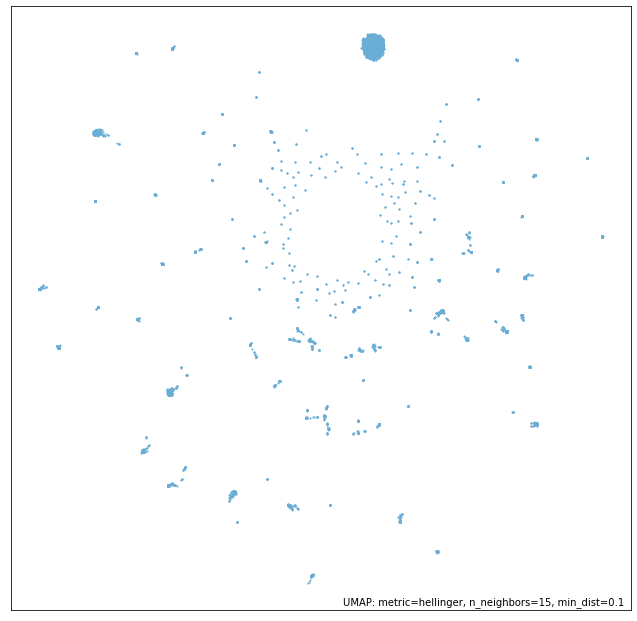

In [28]:
f = umap.plot.points(tfidf_embedding)